In [1]:
import os
from time import time

from dotenv import load_dotenv
from qiskit import QuantumCircuit, transpile
from qiskit.providers import BackendV2 as Backend
from qiskit.transpiler import generate_preset_pass_manager
from qiskit.visualization import plot_histogram
from qiskit_aer import AerSimulator
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import SamplerV2 as Sampler
from qiskit_ibm_runtime.fake_provider import FakeFez

# Práctica HW2: Hardware Cuántico

## Construcción del circuito

Primero de todo construimos el circuito indicado.

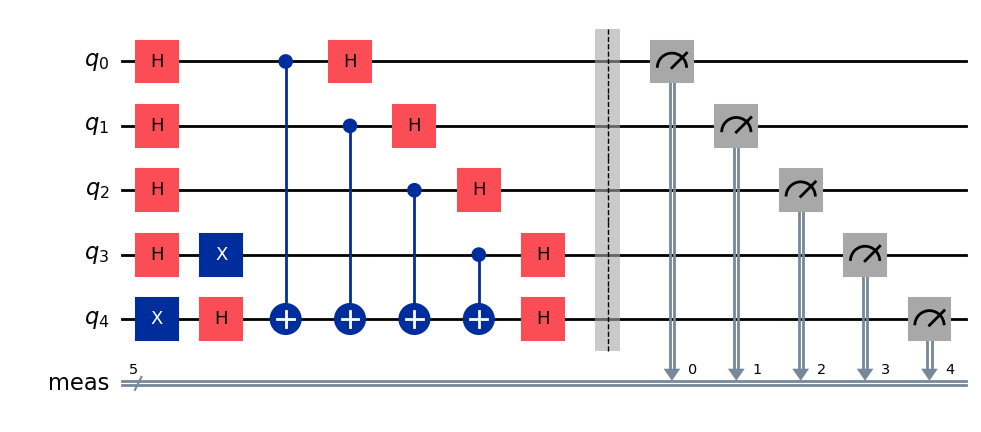

In [2]:
qc = QuantumCircuit(5)

qc.x(4)
qc.h(range(5))
qc.x(3)

for i in range(4):
    qc.cx(i, 4)

qc.h(range(5))

qc.measure_all()

qc.draw(output="mpl")

## Impacto de los niveles de optimización

Primero de todo, definimos una función que dado un circuito y un backend, transpila el circuito con un cierto nivel de optimización e imprime por pantalla el tiempo de transpilación, la profundidad del circuito transpilado y muestra el circuito transpilado.

In [3]:
def get_info(
    qc: QuantumCircuit, backend: Backend, optimization_level: int
) -> QuantumCircuit:
    start = time()
    transpiled_circuit = transpile(qc, backend, optimization_level=optimization_level)
    end = time()

    print(f"Tiempo de transpilación: {end - start}")
    print(f"Profundidad: {transpiled_circuit.depth()}")
    display(transpiled_circuit.draw(output="mpl"))

    return transpiled_circuit

### Fake Backend

In [4]:
backend = FakeFez()

- `optimization_level=0`

Tiempo de transpilación: 0.3797879219055176
Profundidad: 54


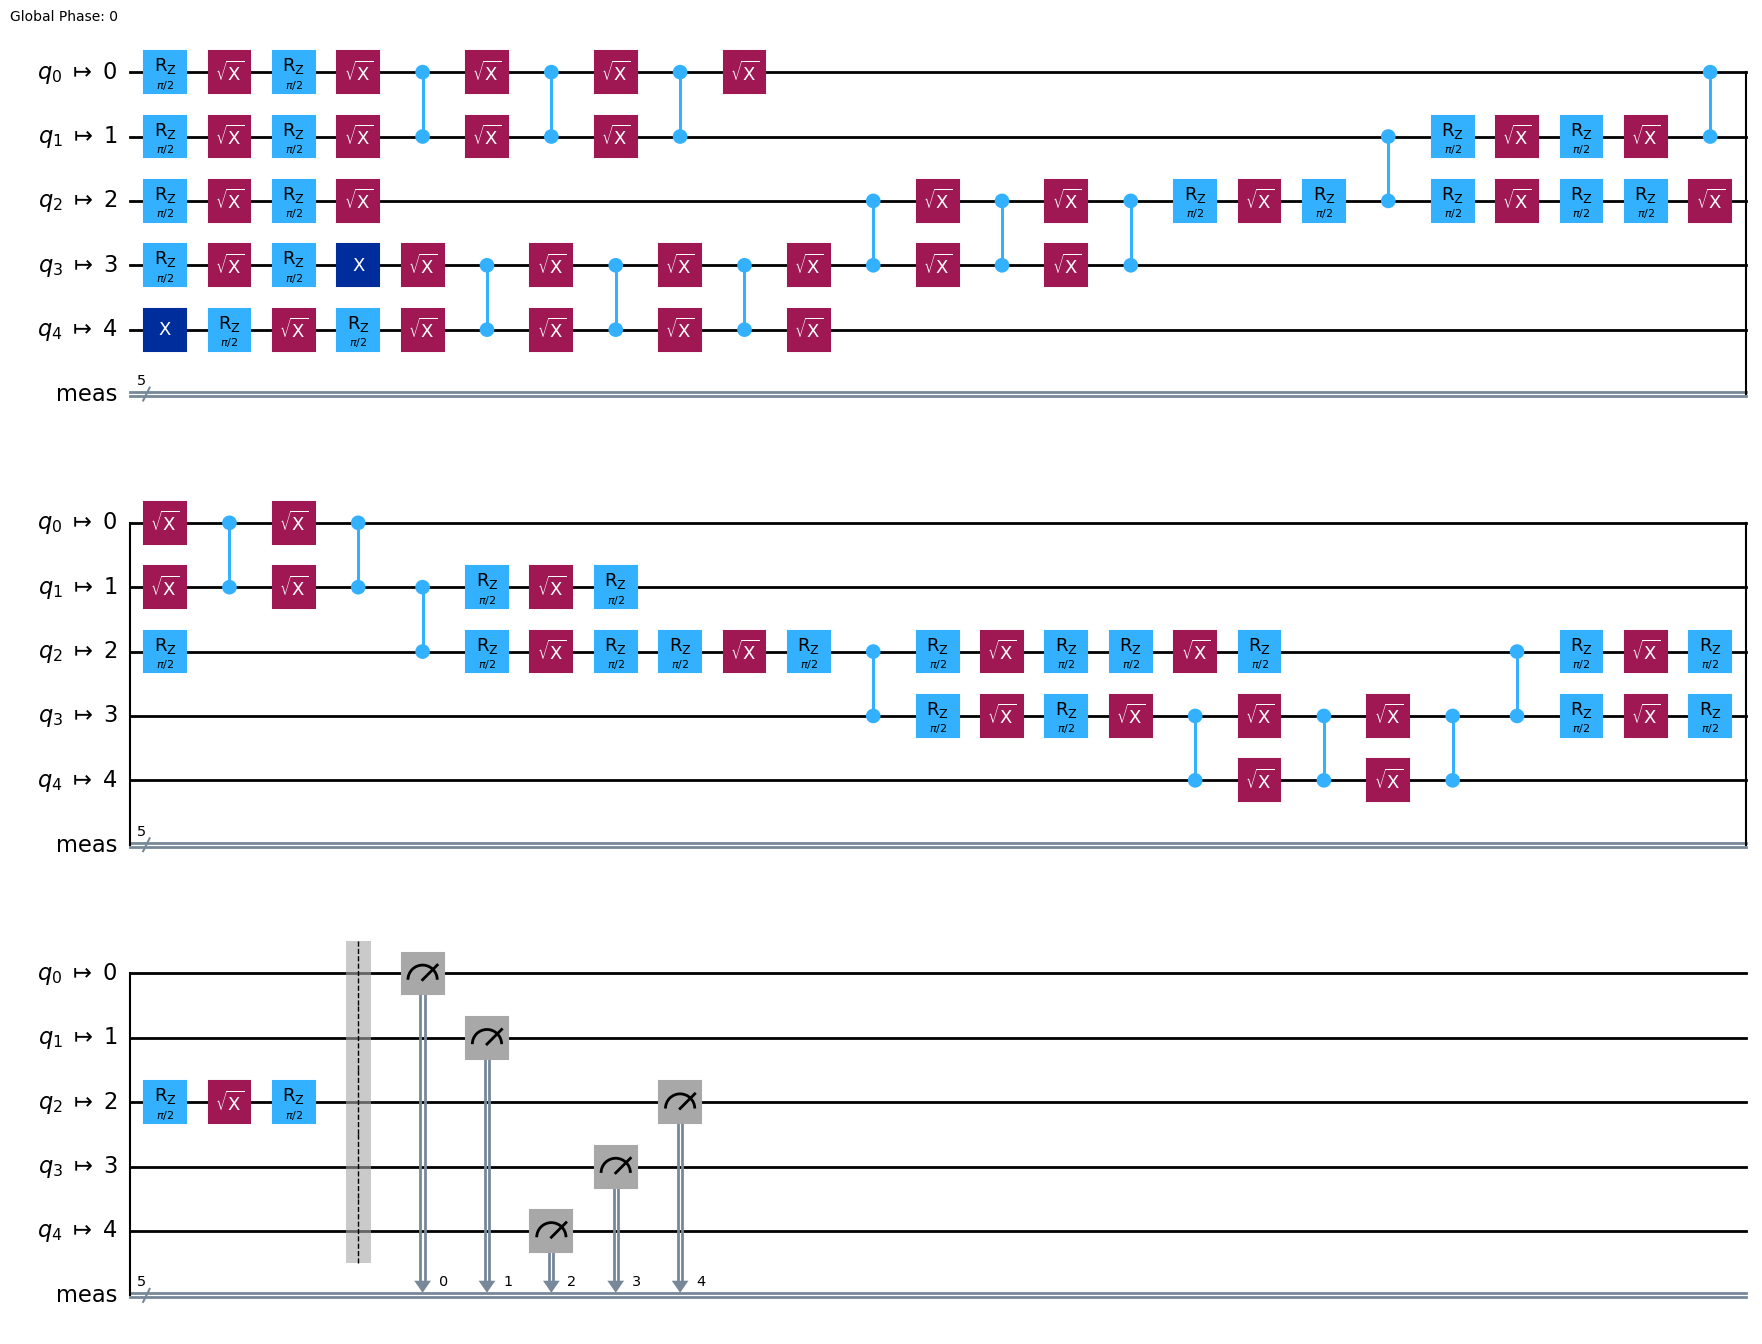

In [5]:
fake_fez_0 = get_info(qc, backend, 0)

El nivel 0 mapea el circuito al hardware, es decir, descompone las puertas que definimos a las puertas que realmente implementa el chip. Además, si los qubits no están conectados se implementan puertas puertas SWAP correspondientes, pero no se busca reducir el número de puertas.

- `optimization_level=1`

Tiempo de transpilación: 0.024324655532836914
Profundidad: 22


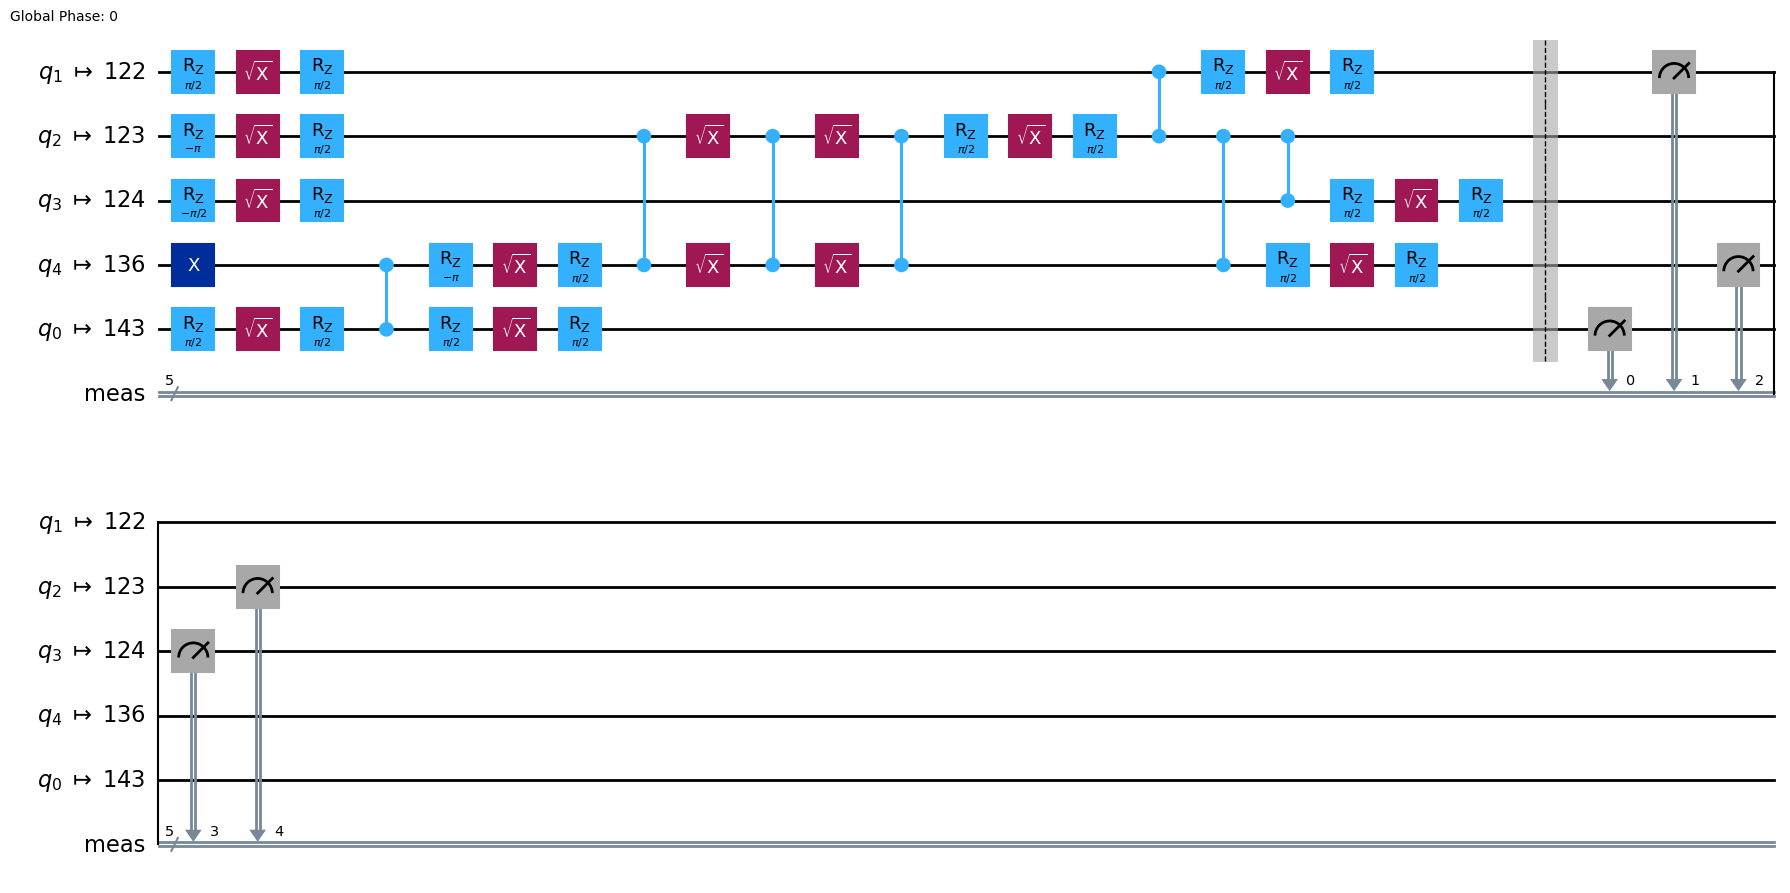

In [6]:
fake_fez_1 = get_info(qc, backend, 1)

Realiza un mapeo y un enrutamiento básico y además realiza ciertas optimizaciones simples. Colapsa puertas adyacentes simples, por ejemplo dos puertas X seguidas se eliminan. 

- `optimization_level=2`

Tiempo de transpilación: 0.02908635139465332
Profundidad: 21


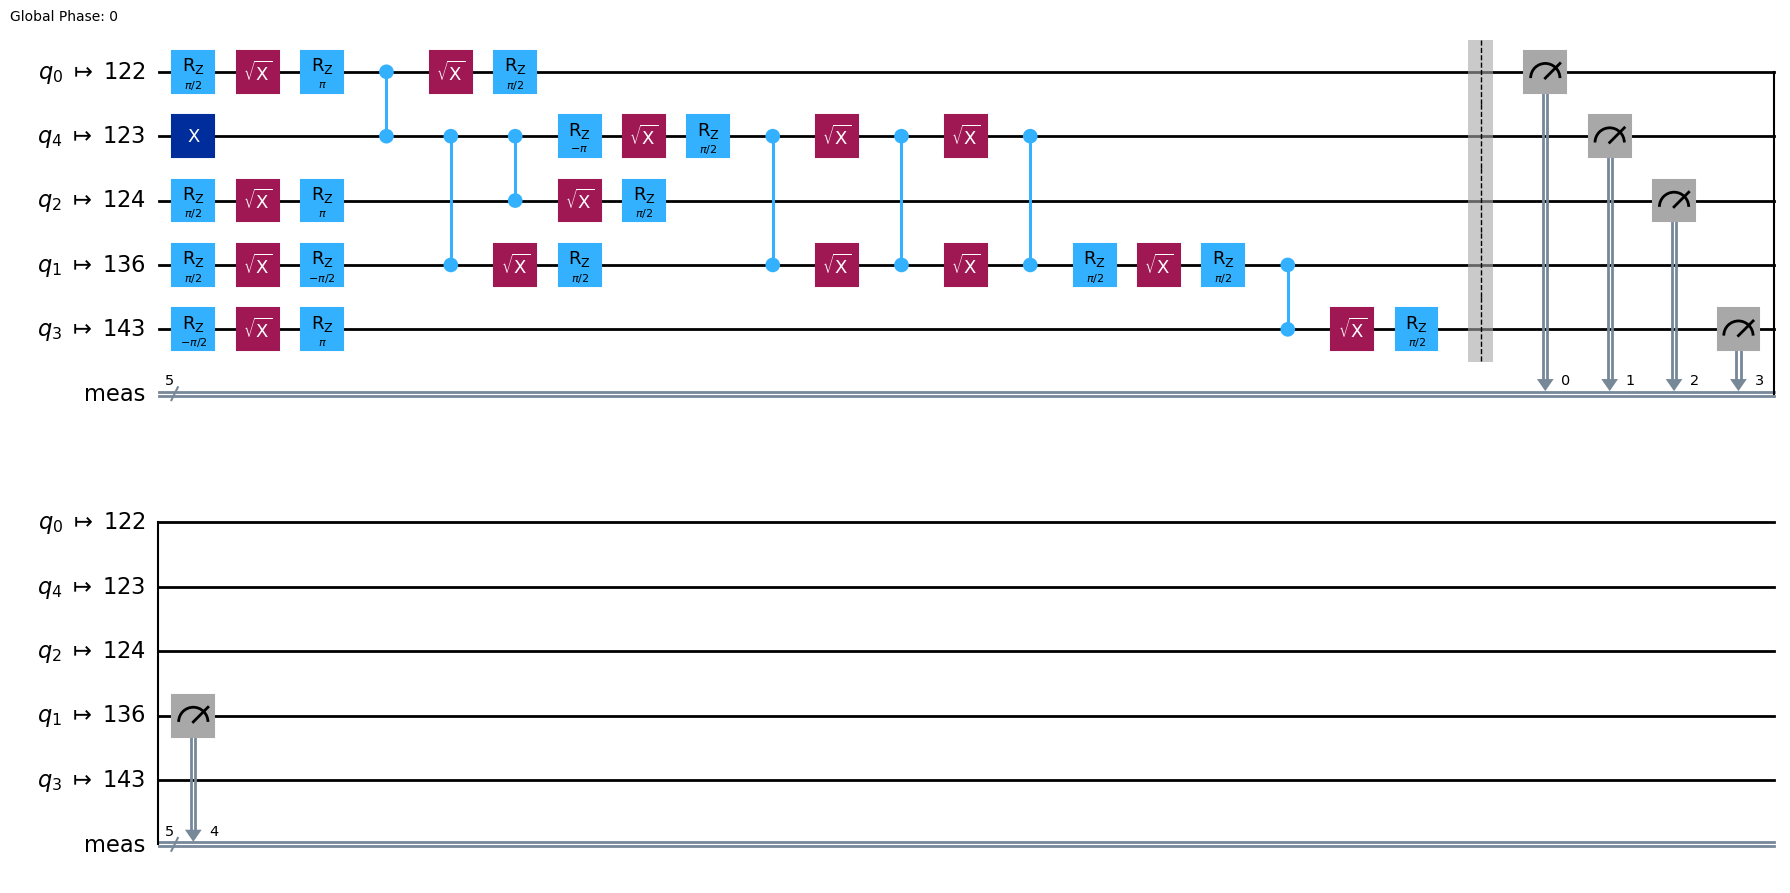

In [7]:
fake_fez_2 = get_info(qc, backend, 2)

Introduce optimizaciones conmutativas (cancelación de puertas si se pueden mover una al lado de la otra) y un mapeo inicial optimizado para el ruido. 

- `optimization_level=3`

Tiempo de transpilación: 0.04189777374267578
Profundidad: 17


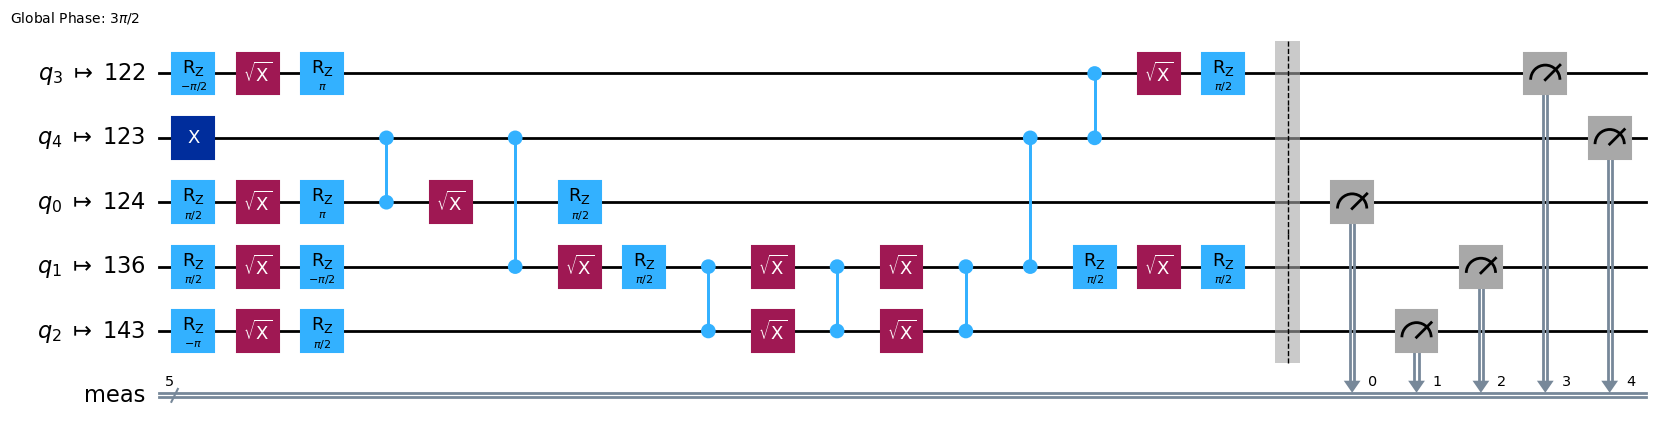

In [8]:
fake_fez_3 = get_info(qc, backend, 3)

El objetivo de este nivel de optimización es obtener el circuito más óptimo posible, sin importar el tiempo de transpilación. Utiliza varios mapeos diferentes y se queda con el mejor de todos.

### Ordenador cuántico real

También podemos realizar este proceso de transpilación para un ordenador cuántico real, aunque como este es un proceso clásico y no cuántico, los resultados serán los mismos que utilizando el Fake Backend correspondiente (obviando que el proceso de transpilación es heurístico).

Para hacerlo, primero de todo cargamos nuestra cuenta y obtenemos el backend real:

In [9]:
load_dotenv()
ibm_key = os.getenv("IBM_KEY")
QiskitRuntimeService.save_account(token=ibm_key, overwrite=True)
service = QiskitRuntimeService()
backend = service.backend("ibm_fez")

qiskit_runtime_service.__init__:WARNING:2025-12-03 01:33:08,838: Instance was not set at service instantiation. Free and trial plan instances will be prioritized. Based on the following filters: (tags: None, region: us-east, eu-de), and available plans: (open), the available account instances are: open-instance. If you need a specific instance set it explicitly either by using a saved account with a saved default instance or passing it in directly to QiskitRuntimeService().
qiskit_runtime_service.backends:WARNING:2025-12-03 01:33:08,840: Using instance: open-instance, plan: open


Con esto, ya podemos realizar la transpilación tal y como lo hacíamos para el Fake Backend. Por ejemplo, realizamos la transpilación del circuito con un nivel de optimización 1:

Tiempo de transpilación: 1.3889567852020264
Profundidad: 19


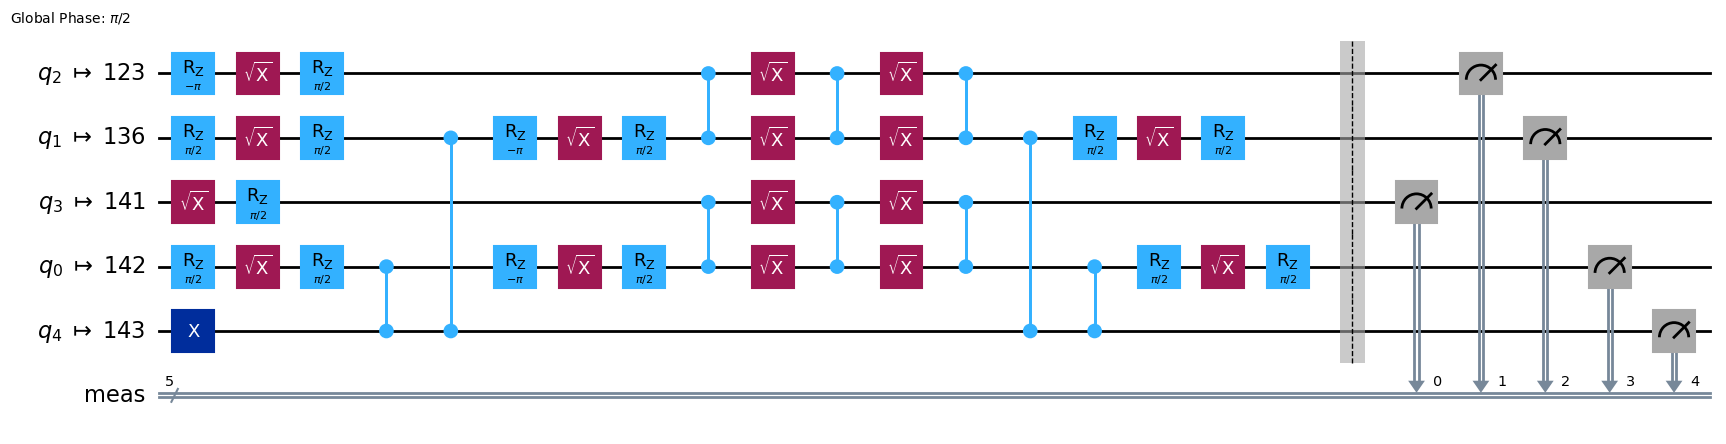

In [10]:
real_fez_1 = get_info(qc, backend, 1)

## Ejecución de los circuitos con distintos niveles de optimización

Primero de todo, definimos una función `run_circuit` que ejecute el circuito y muestre un histograma con los resultados. A diferencia del `run_circuit` de la práctica anterior, en este recibimos un argumento `transpile` para que la función se pueda utilizar tanto con circuitos ya transpilados como circuitos sin transpilar.

In [11]:
def run_circuit(
    qc: QuantumCircuit, backend: Backend, nshots: int = 1000, transpile: bool = True
) -> None:
    if transpile:
        pm = generate_preset_pass_manager(backend=backend, optimization_level=1)
        isa_circuit = pm.run(qc)
    else:
        isa_circuit = qc

    sampler = Sampler(backend, options={"default_shots": nshots})

    job = sampler.run([isa_circuit])
    result = job.result()
    pub_result = result[0]

    display(plot_histogram(pub_result.data.meas.get_counts(), figsize=(5, 4.5)))

Primero de todo, ejecutamos el circuito con un simulador ideal para luego poder hacer la comparación de los distintos circuitos transpilados:

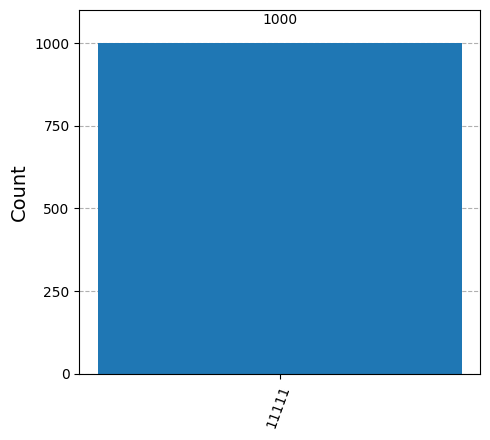

In [12]:
run_circuit(qc, AerSimulator())

Ahora ejecutamos los circuitos transpilados anteriormente:

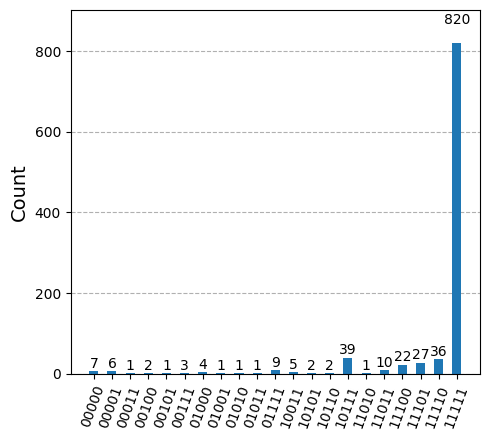

In [13]:
run_circuit(fake_fez_0, FakeFez(), transpile=False)

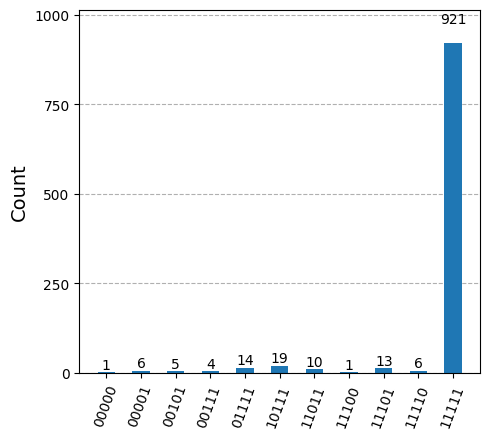

In [14]:
run_circuit(fake_fez_1, FakeFez(), transpile=False)

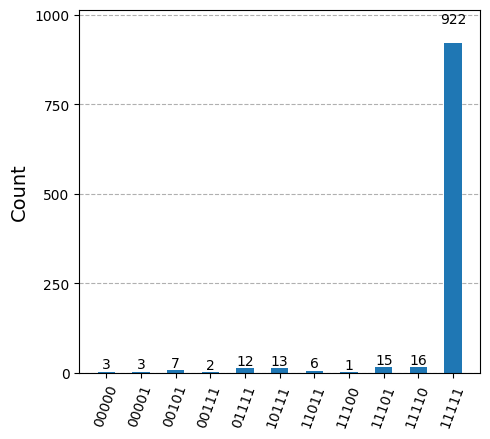

In [15]:
run_circuit(fake_fez_2, FakeFez(), transpile=False)

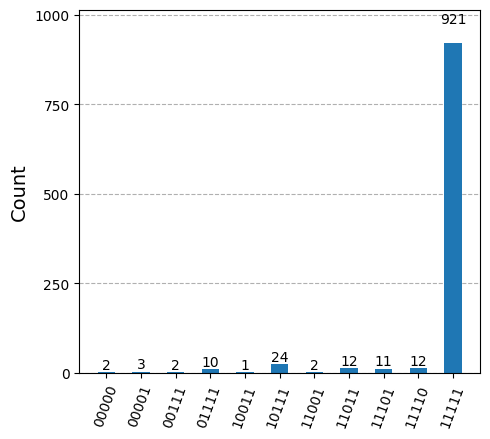

In [16]:
run_circuit(fake_fez_3, FakeFez(), transpile=False)

Como podemos observar en los resultados de la ejecución de los circuitos transpilados sobre el simulador, obtenemos una tasa de fidelidad bastante menor en el circuito con nivel de optimización 0 que en el resto. Esto se debe a que la profundidad de este circuito es mucho más elevada que para el resto de circuitos.

En cuanto al resto de optimizaciones, vemos que la fidelidad es prácticamente la misma. Esto se debe a que los circuitos transpilados con esos niveles de optimización tienen un nivel de profundidad muy similar, lo que hace que esa optimización a mayores no se note demasiado en la fidelidad.

Destacar que la degradación de la fidelidad al aumentar la profundidad del circuito se debe a la naturaleza perecedera y ruidosa de los qubits. Una mayor profundidad incrementa el tiempo total de ejecución, exponiendo información cuántica a la decoherencia. Además, al encadenar una mayor secuencia de operaciones imperfectas (las puertas tienen cierta tasa de error), los errores de puerta se acumulan multiplicándose, lo que reduce la fidelidad.

## Comparativa entre mayor y menor profundidad

A continuación, realizamos 100 transpilaciones y nos quedamos con los circuitos de mayor y menor profundidad.

La razón por la que obtenemos profundidades diferentes para un mismo circuito, backend y nivel de optimización radica en la naturaleza de los algoritmos de asignación y enrutamiento que utiliza el transpilador.

El problema de mapear un circuito lógico a una topología física con conectividad limitada es un problema NP-duro. Para resolverlo en tiempos razonables, Qiskit emplea algoritmos heurísticos estocásticos. Como estos algoritmos dependen de una semilla que por defecto es aleatoria, distintas ejecuciones generan resultados diferentes, lo que produce una variación en el número de puertas agregadas y, por lo tanto, en la profundidad final del circuito.

In [17]:
max_depth_circuit = None
min_depth_circuit = None
min_depth = float("inf")
max_depth = -1

for i in range(100):
    temp_qc = transpile(qc, backend, optimization_level=1)
    current_depth = temp_qc.depth()

    if current_depth < min_depth:
        min_depth = current_depth
        min_depth_circuit = temp_qc

    if current_depth > max_depth:
        max_depth = current_depth
        max_depth_circuit = temp_qc

print(f"Max depth {max_depth}")
print(f"Min depth {min_depth}")

Max depth 33
Min depth 17


Ejecutamos los 2 circuitos en un Fake Backend.

*Nota sobre la ejecución: debido a que a la hora de ejecutar el notebook las colas de acceso a los distintos ordenadores cuánticos de IBM están saturadas (varias horas de espera), se ha optado por ejecutar esta comparativa final utilizando un Fake Backend. De todas maneras, dado que este simulador simula un ordenador cuántico real que se encuentra disponible en estos momentos, el resultado de ejecutar el circuito en dicho ordenador real sería muy similar al obtenido mediante el simulador.*

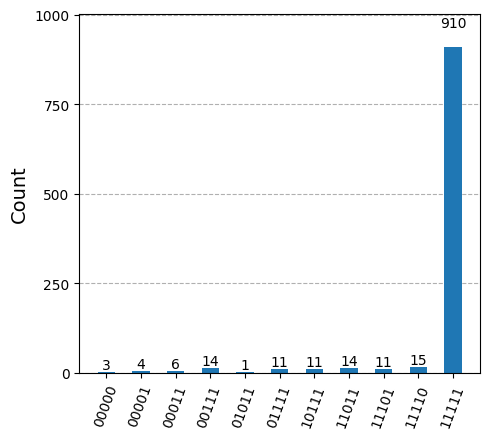

In [18]:
run_circuit(max_depth_circuit, FakeFez(), transpile=False)

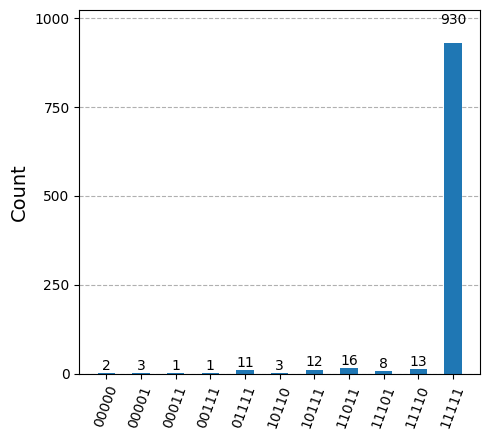

In [19]:
run_circuit(min_depth_circuit, FakeFez(), transpile=False)

Tras haber ejecutado ambos circuitos en varias ocasiones, observamos que el porcentaje de veces que obtenemos la salida correcta es bastante similar, aunque los resultados son ligeramente mejores para el caso con menor profundidad.

Como hemos comentado anteriormente, como los ordenadores cuánticos reales tienen cierta tasa de error al realizar operaciones, este error se va multiplicando, por lo que cuanta más profundidad tenga el circuito, mayor será el error.

Sin embargo, en este caso estamos hablando de unas profundidades de 17 y 33, por lo que, aunque el más profundo tiene casi el doble de profundidad que el menos profundo, 33 sigue siendo una profundidad relativamente baja por lo que la diferencia en cuanto a la fidelidad tampoco es muy notoria (en este caso es del 2%, pero dependiendo de la ejecución puede ser menor al 1%).